# Exploratory Data Analysis for NASDAQ Bank Stocks
#### Data from https://www.nasdaq.com/market-activity/stocks/screener (Sector: Financial)

<br/><br/>

### Author: Reynaldi Aditama

### About: Conducting an exploratory analysis to identify metrics correlated with NASDAQ bank stock prices over the past five years.

### Runtime: If kernel is restarted and run all cells, it will take approx. 5 minutes

### How to Navigate: Using left bar (the three horizontal lines to see table of content)

<br/>

### 1. Process

#### RUN THIS IF YOU DIDN'T HAVE ALL OF THE PACKAGES AND WANT TO RUN ALL THE CELLS

In [1]:
!pip install yfinance pandas numpy matplotlib scipy dash dash_bootstrap_components

#### All import statements

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import collections
import math
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
from scipy import stats
from dash import dcc, html, Input, Output, jupyter_dash, Dash, callback, State
from plotly.subplots import make_subplots

#### Timer for all cells

In [3]:
start = timeit.default_timer()

#### Extracting and cleaning data 

In [4]:
total_stocks = 0

df = pd.read_csv('data/bank_tickers.csv',
                header=0,
                usecols=['Symbol', 'Market Cap', 'Industry'])

df.columns = ['ticker', 'mc', 'industry']  # changing the header

df = df.dropna()
df = df.drop(df[(df.mc < 1) | (df.industry != 'Major Banks')].index)  # selecting from major banks only
df = df.reset_index()

# removing stocks that don't have complete financial information
for x in df['ticker']:
    data = yf.Ticker(x).get_balance_sheet()
    if data.empty:
        df = df.drop(df.index[df['ticker'] == x])
    else:
        total_stocks += 1

df = df.reset_index()
display(df.head())
print('Total stocks: ', total_stocks)

,level_0,index,ticker,mc,industry
0,0,6,ABCB,3.478168e+09,Major Banks
1,1,21,ACNB,3.087910e+08,Major Banks
2,2,62,ALLY,1.193430e+10,Major Banks
3,3,63,ALRS,3.822853e+08,Major Banks
4,4,68,AMAL,8.253700e+08,Major Banks


Total stocks:  308


#### Labelling stocks based on market capitalization

In [5]:
conditions = [
    df.mc >= 200_000_000_000,
    (df.mc >= 10_000_000_000) & (df.mc < 200_000_000_000),
    (df.mc >= 2_000_000_000) & (df.mc < 10_000_000_000),
    (df.mc >= 300_000_000) & (df.mc < 2_000_000_000),
    (df.mc >= 50_000_000) & (df.mc < 300_000_000),
    df.mc < 50_000_000
]

labels = ['Mega', 'Large', 'Medium', 'Small', 'Micro', 'Nano']

df['labels'] = np.select(conditions, labels, 'unknown')
df.head()

,level_0,index,ticker,mc,industry,labels
0,0,6,ABCB,3.478168e+09,Major Banks,Medium
1,1,21,ACNB,3.087910e+08,Major Banks,Small
2,2,62,ALLY,1.193430e+10,Major Banks,Large
3,3,63,ALRS,3.822853e+08,Major Banks,Small
4,4,68,AMAL,8.253700e+08,Major Banks,Small


#### Finding the time when price gained significant increase
#### Significant: Searching peak with prominance of 15% of the all time high

Preview finding peak and valley


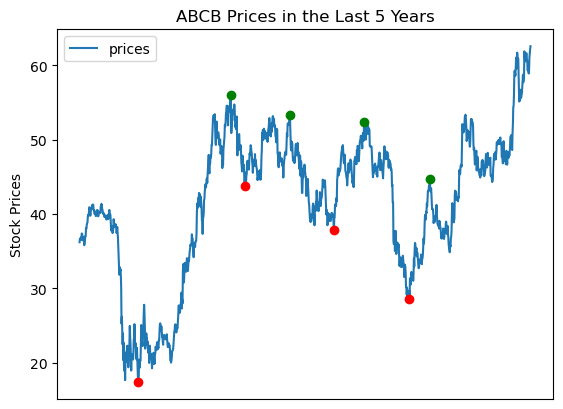

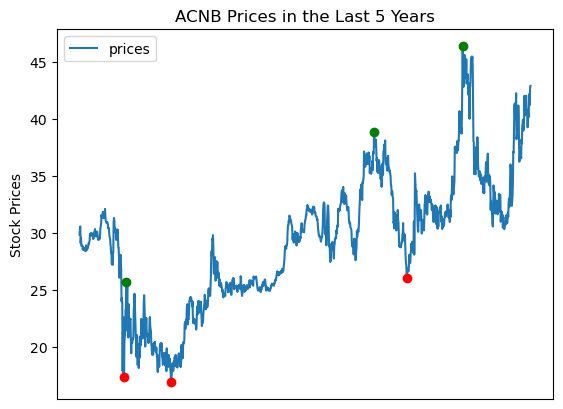

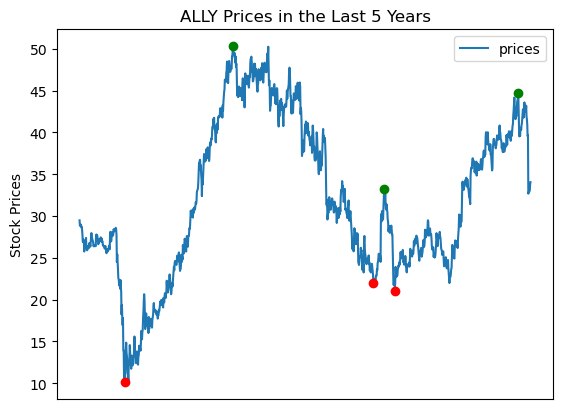

red dot: valley
green dot: peak


In [6]:
tickers = []
prices = []
pairs = [[] for _ in range(total_stocks)]
hists = []

# saving tickers and prices for all banking stocks
# return: the corresponding ticker and price
def save_as_local_variable(sym):
    global tickers, prices, hists

    ticker = yf.Ticker(sym)
    check_hist = ticker.history(period='max').reset_index()

    if len(check_hist) < 1258:  # check if the company has been public for at least 5y
        hist = check_hist
    else:
        hist = ticker.history(period='5y').reset_index()
    
    price = hist['Close'].values

    tickers.append(ticker)
    prices.append(price)
    hists.append(hist)

    return ticker, price

# finding all peaks and valleys from all stocks
# return: the peak and valley
def peak_and_valley_finder(sym):
    _, price = save_as_local_variable(sym)

    if len(price) == 0:  # check if the array is empty or not
        return [], []
    else:
        neg_price = price * -1

        prominence_price = max(price) * 0.15
        peak, _ = find_peaks(price, prominence=prominence_price)
        valley, _ = find_peaks(neg_price, prominence=prominence_price)

        return peak, valley

# finding the peak and valley pairs
def find_pairs():
    global pairs
    for i in range(total_stocks):
        p, v = peak_and_valley_finder(df['ticker'].values[i])

        if (len(p) > 1) & (len(v) > 1):  # pair the peak and valley
            n = m = 0  # n is for valley and m is for peak
            while (n < len(v)) & (m < len(p)):
                if v[n] < p[m]:
                    pairs[i].append([v[n], p[m]])
                    n += 1
                    m += 1
                else:
                    m += 1

# preview the first three stocks
def preview_peak_and_valley():
    global pairs, prices
    
    for i in range(3):
        plt.subplots()
        plt.plot(prices[i], label='prices')
        
        for j in range(len(pairs[i])):
            plt.plot(pairs[i][j][0], prices[i][pairs[i][j][0]], 'ro')
            plt.plot(pairs[i][j][1], prices[i][pairs[i][j][1]], 'go')
            
        plt.title(df.ticker[i] + ' Prices in the Last 5 Years')
        plt.xticks([])  # removing x axis values
        plt.ylabel('Stock Prices')
        plt.legend()

find_pairs()
print('Preview finding peak and valley')
preview_peak_and_valley()
plt.show()
print('red dot: valley\ngreen dot: peak')

#### Making metric dictionary for each stocks

In [7]:
metric_dict = [{} for _ in range(total_stocks)]

# making a metric dictionary from each stock from balance sheet, income statement, and cash flow
def make_metric_dict():
    global metric_dict, tickers

    for i in range(total_stocks):  # Transforming each data frame to dictionary
        bs = tickers[i].get_balance_sheet().reset_index().set_index('index').T.to_dict() 
        cf = tickers[i].get_cashflow().reset_index().set_index('index').T.to_dict()
        inc = tickers[i].get_income_stmt().reset_index().set_index('index').T.to_dict()
    
        # Merging and sorting the dictionary based on alphabetical order (keys)
        metric_dict[i] = collections.OrderedDict(sorted({**bs, **cf, **inc}.items()))

make_metric_dict()

#### Filling the data gaps using cubic interpolation since the metrics only give us 5 data points (yearly)

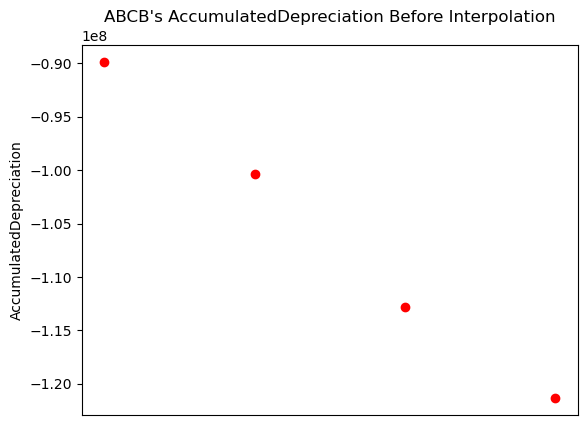

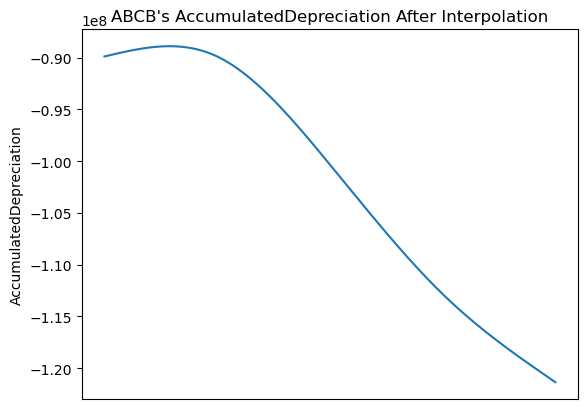

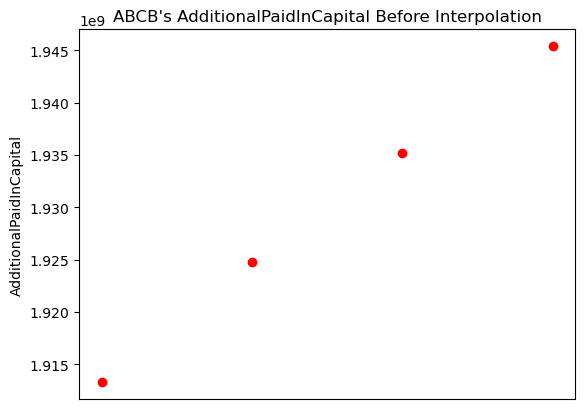

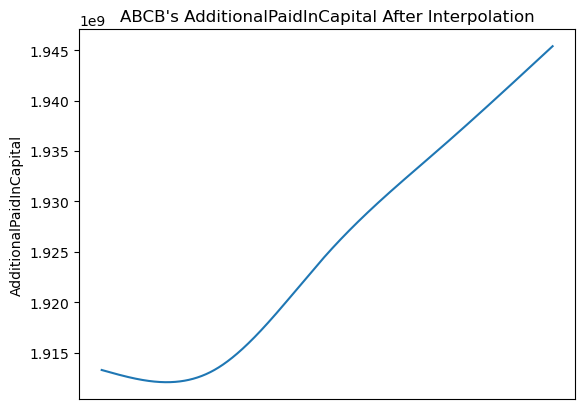

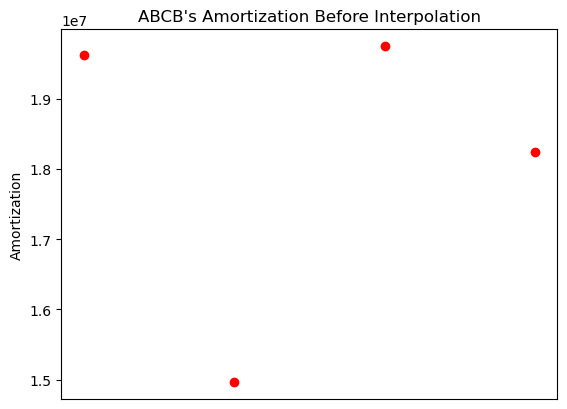

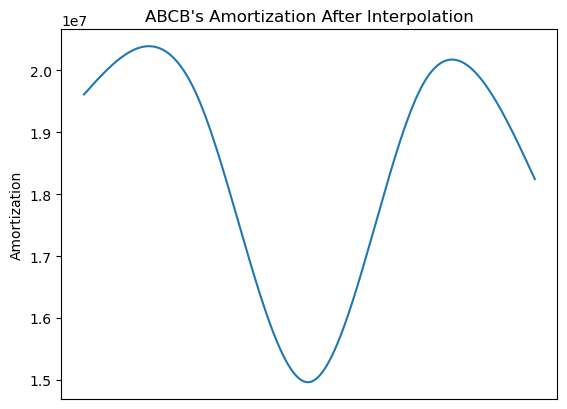

In [8]:
interpolates = [[] for _ in range(total_stocks)]

# finding the interpolation data
def cubic_interpolate():
    global metric_dict, interpolates
    
    for i in range(total_stocks):
        for key in metric_dict[i]:

            values = list(metric_dict[i][key].values())
            y = []

            for j in range(len(values)):  
                if math.isnan(values[j]):
                    y.append(0 if j == 0 else y[j-1])  # use the last value that is not nan for nan
                else:
                    y.append(values[j])
        
            x = [0, 314, 629, 942, 1257]  # year 1, year 2, ... , year 5
            y = y[::-1]  # reverse since the data is backward, i.e, 2023 - 2019, we want 2019 - 2023
        
            # homogenized length of x and y if different
            if len(x) != len(y):
                x = x[:len(y)]

            cs = CubicSpline(x, y, bc_type='natural')
            x_new = np.linspace(0, 1257, 1258)  # 5 years of historical price
            y_new = cs(x_new)

            interpolates[i].append(y_new)

# preview the interpolation results for the three metrics in the first stock
def preview_interpolation():
    ticker = df.ticker[0]
    keys = list(metric_dict[0].keys())[0:3]

    for i in range(3):
        plt.subplots()
        plt.plot(list(metric_dict[0][keys[i]].values())[::-1], 'ro')
        plt.title(ticker + "'s " + keys[i] + ' Before Interpolation')
        plt.xticks([])  
        plt.ylabel(keys[i])
        
        plt.subplots()
        plt.plot(interpolates[0][i])
        plt.title(ticker + "'s " + keys[i] + ' After Interpolation')
        plt.xticks([])  
        plt.ylabel(keys[i])

cubic_interpolate()
preview_interpolation()

#### Finding the correlated metric and the stock price using Kendall's Tau coefficient
#### Remarks: The Kendall's Tau coefficient can be NaN if we failed to find the pairs (peak and valley in stock prices)

In [9]:
correlated_metrics = [{} for _ in range(total_stocks)]

# getting price from certain pair index
def get_price_from_pair(index):
    global prices, pairs

    local_pairs = pairs[index]
    ret = []
    
    for i in local_pairs:
        ret.append(prices[index][i[0]:i[1]])
        
    return ret

# getting interpolation data from certain pair index
def get_interpolation_from_pair(interpolation_index, index):
    global interpolates, pairs

    local_pairs = pairs[index]
    ret = []
    
    for i in local_pairs:
        ret.append(interpolates[index][interpolation_index][i[0]:i[1]])
    
    return ret

# finding the Kendall Tau coefficient for each metric
def find_kendall_tau():
    global correlated_metrics

    for i in range(total_stocks):
        metric_name = list(metric_dict[i].keys())

        correlated_metrics[i] = dict.fromkeys(metric_name, float('nan'))  
        x = get_price_from_pair(i)

        for j in range(len(interpolates[i])):
            
            tau = 0
            y = get_interpolation_from_pair(j, i)

            if len(x) != 0:
                for k in range(len(x)):  # find kendall's tau for each pair
                    res = stats.kendalltau(x[k], y[k])
                    tau += res.statistic  # tau coefficient
                
                correlated_metrics[i][metric_name[j]] = tau / len(x)

# print the kendall tau for the first stock
def preview_kendall_tau(i):
    length = 0
    print('----------------------------------')
    header = '--- ' + df['ticker'].values[i] + ' | ' + df['labels'].values[i] + ' Bank Preview ---'
    print(header)        
    for key in correlated_metrics[i]:
        if length == 3:
            break
        print(key + ': ' + '%.3f' % float(correlated_metrics[i][key]))
        length += 1
    print('----------------------------------')

find_kendall_tau()
preview_kendall_tau(0)

----------------------------------
--- ABCB | Medium Bank Preview ---
AccumulatedDepreciation: -0.582
AdditionalPaidInCapital: 0.582
Amortization: 0.030
----------------------------------


#### Combining the result based on market cap

In [10]:
mega = {}
large = {}
medium = {}
small = {}
micro = {}
nano = {}

counter = 0

# merging dictionaries
def merge_dict(d1, d2):
    for key in set(d2.keys()):
        if not math.isnan(d2[key]):
            if key in d1:
                if type(d1[key]) is list:
                    d1[key].append(d2[key])
                else:
                    temp = d1[key]
                    d1[key] = [temp, d2[key]]
            else:
                d1[key] = d2[key]

# getting the correlation result based on market cap
for i in df['labels']:
    if i == 'Mega':
        merge_dict(mega, correlated_metrics[counter])

    if i == 'Large':
        merge_dict(large, correlated_metrics[counter])

    if i == 'Medium':
        merge_dict(medium, correlated_metrics[counter])

    if i == 'Small':
        merge_dict(small, correlated_metrics[counter])

    if i == 'Micro':
        merge_dict(micro, correlated_metrics[counter])

    if i == 'Nano':
        merge_dict(nano, correlated_metrics[counter])

    counter += 1

# preview the result of combined dictionaries, only mega
def preview_combined():
    print('Mega Banks Preview')
    length = 0
    for key in mega:
        if length == 3:
            break
        print(key + ': ', mega[key])
        length += 1

preview_combined()

Mega Banks Preview
NetShortTermDebtIssuance:  [0.24898124438787314, 0.27739815666694556]
NetInterestIncome:  [0.8428606071913755, 0.26066778044117334]
RepaymentOfDebt:  [-0.16816759951950697, 0.11429573435304019]


#### Finding mean for each metrics in the combined dictionary

In [11]:
# calculating mean for each metrics
def find_mean_dict():
    for k in mega:
        if type(mega[k]) is list:
            length = len(mega[k])
            sum = 0
            for i in mega[k]:
                sum += i
            mega[k] = sum / length

    for k in large:
        if type(large[k]) is list:
            length = len(large[k])
            sum = 0
            for i in large[k]:
                sum += i
            large[k] = sum / length

    for k in medium:
        if type(medium[k]) is list:
            length = len(medium[k])
            sum = 0
            for i in medium[k]:
                sum += i
            medium[k] = sum / length

    for k in small:
        if type(small[k]) is list:
            length = len(small[k])
            sum = 0
            for i in small[k]:
                sum += i
            small[k] = sum / length

    for k in micro:
        if type(micro[k]) is list:
            length = len(micro[k])
            sum = 0
            for i in micro[k]:
                sum += i
            micro[k] = sum / length

    for k in nano:
        if type(nano[k]) is list:
            length = len(nano[k])
            sum = 0
            for i in nano[k]:
                sum += i
            nano[k] = sum / length
            
find_mean_dict()
preview_combined()

Mega Banks Preview
NetShortTermDebtIssuance:  0.26318970052740936
NetInterestIncome:  0.5517641938162744
RepaymentOfDebt:  -0.026935932583233388


<br />

### 2. Result

#### Ranking the correlated metrics using Kendall Tau Coefficient based on market cap
#### Remarks: The negative sign is just the way of the metrics correlated to the price, we only care about the value, not the sign

In [12]:
sorted_mega = sorted(mega.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_large = sorted(large.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_medium = sorted(medium.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_small = sorted(small.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_micro = sorted(micro.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_nano = sorted(nano.items(), key=lambda x: abs(x[1]), reverse=True)

cols = ['Metrics', 'Kendall Tau Coefficient']

# transform list to dict
# return dict from list
def list_to_dict(l):
    key = [x[0] for x in l]
    value = [x[1] for x in l]
    return dict(zip(key, value))

mega_result = pd.DataFrame(list_to_dict(sorted_mega).items(), columns=cols)
large_result = pd.DataFrame(list_to_dict(sorted_large).items(), columns=cols)
medium_result = pd.DataFrame(list_to_dict(sorted_medium).items(), columns=cols)
small_result = pd.DataFrame(list_to_dict(sorted_small).items(), columns=cols)
micro_result = pd.DataFrame(list_to_dict(sorted_micro).items(), columns=cols)
nano_result = pd.DataFrame(list_to_dict(sorted_nano).items(), columns=cols)

# print all the results
def result():
    print('Mega Banks')
    display(mega_result)
    
    print('\nLarge Banks')
    display(large_result)
    
    print('\nMedium Banks')
    display(medium_result)
    
    print('\nSmall Banks')
    display(small_result)
    
    print('\nMicro Banks')
    display(micro_result)
    
    print('\nNano Banks')
    display(nano_result)

result()

Mega Banks


,Metrics,Kendall Tau Coefficient
0,CommonStock,-0.847137
1,ShareIssued,-0.847137
2,BasicAverageShares,-0.734382
3,DilutedAverageShares,-0.674499
4,OtherEquityInterest,0.667104
...,...,...
157,NetIncomeFromContinuingOperations,-0.011499
158,OtherReceivables,-0.008377
159,TradingSecurities,0.008082
160,NetIssuancePaymentsOfDebt,-0.006502



Large Banks


,Metrics,Kendall Tau Coefficient
0,FixedAssetsRevaluationReserve,-0.682202
1,ForeignCurrencyTranslationAdjustments,0.682202
2,ChangeInTaxPayable,0.549438
3,ChangeInIncomeTaxPayable,0.549438
4,CurrentProvisions,-0.549438
...,...,...
231,TaxRateForCalcs,0.006135
232,TaxEffectOfUnusualItems,-0.003721
233,CapitalStock,-0.001575
234,DepreciationAmortizationDepletionIncomeStatement,-0.000676



Medium Banks


,Metrics,Kendall Tau Coefficient
0,DividendsPayable,0.795953
1,EffectOfExchangeRateChanges,-0.475363
2,RetainedEarnings,0.474421
3,CurrentCapitalLeaseObligation,-0.408852
4,PurchaseOfInvestmentProperties,-0.383716
...,...,...
221,LongTermDebtAndCapitalLeaseObligation,0.010027
222,GoodwillAndOtherIntangibleAssets,-0.009328
223,GainLossOnSaleOfPPE,-0.006890
224,NetPPE,0.002409



Small Banks


,Metrics,Kendall Tau Coefficient
0,CurrentDeferredAssets,-0.533681
1,NonCurrentDeferredAssets,0.533681
2,CurrentDeferredLiabilities,-0.533681
3,NonCurrentPrepaidAssets,0.533681
4,OtherCurrentLiabilities,0.533681
...,...,...
267,InterestExpenseNonOperating,0.000041
268,EBIT,0.000041
269,CurrentLiabilities,0.000041
270,OperatingIncome,0.000041



Micro Banks


,Metrics,Kendall Tau Coefficient
0,OtherNonOperatingIncomeExpenses,0.694068
1,DepreciationIncomeStatement,0.536935
2,DefinedPensionBenefit,-0.439513
3,CashFromDiscontinuedOperatingActivities,-0.417338
4,RetainedEarnings,0.409575
...,...,...
217,GainLossOnSaleOfBusiness,-0.002897
218,RepaymentOfDebt,-0.002569
219,OperatingCashFlow,-0.001703
220,DividendsReceivedCFI,-0.000454



Nano Banks


,Metrics,Kendall Tau Coefficient
0,CurrentCapitalLeaseObligation,-0.799221
1,WorkingCapital,0.799221
2,AllowanceForDoubtfulAccountsReceivable,-0.799221
3,GrossAccountsReceivable,-0.799221
4,TotalNonCurrentAssets,-0.799221
...,...,...
221,ProceedsFromStockOptionExercised,-0.011106
222,NetPPEPurchaseAndSale,-0.010980
223,SaleOfInvestment,-0.007738
224,BeginningCashPosition,-0.002231


#### Utility Function for Visualization

In [13]:
# make dict for bank size
def df_to_dict_label():
    ret = {}
    for label in labels:
        ret[label] = list(df.loc[df['labels'] == label]['ticker'])
    return ret

# make data frame for line graph
def data(index):
    dict_data = {
        'date': [],
        'price': prices[index]
    }

    for j in hists[index]['Date']:
        dict_data['date'].append(j.date())
    
    return pd.DataFrame(dict_data)   

# get the x and y coordinate for certain pairs
def get_x_pairs(index, df_graph):
    x = []
    
    for j in pairs[index]:
        dates = list(df_graph.loc[j]['date'])
        x.append([dates[0], dates[1]])
        
    return x

# combining all the results
def combined_kendall_df():
    return list([mega_result.head(10), large_result.head(10), medium_result.head(10), small_result.head(10), 
                 micro_result.head(10), nano_result.head(10)])

combined_kendall = combined_kendall_df()

all_options = df_to_dict_label()

# get index for certain label
def get_label_index(selected_label):
    if selected_label == 'Mega':
        return 0
    elif selected_label == 'Large':
        return 1
    elif selected_label == 'Medium':
        return 2
    elif selected_label == 'Small':
        return 3
    elif selected_label == 'Micro':
        return 4
    else:
        return 5

# get y-value for each metric
def get_y_graph(index, label_index):
    y = []
    keys = list(combined_kendall[label_index]['Metrics'])
    
    for k in keys:
        value = []
        try:
            value = interpolates[index][list(metric_dict[index]).index(k)]
        except:
            value = []
        y.append(value)

    return y

#### Dash App Layout

In [14]:
app = Dash(__name__)
app.layout = html.Div(
    [
        html.H1(children='Interactive Dashboard for Stock Price and Correlated Metrics'),

        html.H3(children='Pick the bank size then the stock'),   

        dcc.RadioItems(
            list(all_options.keys()),
            'Mega',
            id='stock_label',
        ),

        html.Hr(),

        dcc.Dropdown(id='individual_stock'),

        html.Hr(),

        html.Div([
            
            html.Div([
                
                html.H3(id='table_title'),
                
                html.Div(dcc.Graph(id='kendall_table'), id='parent_table'),
                
            ], style={'display': 'inline-block', 'vertical-align': 'top', 'width': 400}),

            html.Div([
                
                html.H3(children='Graphs for Each Correlated Metric'),

                html.Div(dcc.Graph(id='metric_graphs'), id='parent_metric'),
                
            ], style={'display': 'inline-block', 'vertical-align': 'top', 'width': 800}),
            
        ], style={'width': '95vw', 'height': 500, 'padding': 0}),

        html.Div(dcc.Graph(id='main_graph'), id='parent', style={'width': '95vw'}),

        html.H4(children='Notes One: Stock with no bull time means we failed to find the peak and valley in its price with prominence of 15% from its all-time high'),

        html.H4(children="Notes Two: If the metric graph shows nothing, it means the metric information isn't complete"),

        html.H4(children='Notes Three: All graphs are interactive (zoomed and panned)')
        
    ], style={'marginBottom': 20, 'marginTop': 20, 'marginLeft': 50, 'marginRight': 50}
)

#### Callback Functions for Dash

In [15]:
@callback(
    Output('individual_stock', 'options'),
    Input('stock_label', 'value'))
def set_label(selected_label):
    return [{'label': i, 'value': i} for i in all_options[selected_label]]

@callback(
    Output('individual_stock', 'value'),
    Input('individual_stock', 'options'))
def set_stock(available_options):
    return available_options[0]['value']

@callback(
    Output('parent', 'children'),
    Input('stock_label', 'value'),
    Input('individual_stock', 'value'))
def graphing_price(selected_label, selected_stock): 
    index = df.index[df['ticker'] == selected_stock][0]
    data_graph = data(index)
    x = get_x_pairs(index, data_graph)

    fig = px.line(data(index), x="date", y="price", title=selected_stock + ' - ' + selected_label + ' Bank')

    for i in x:
        
        fig.add_vrect(
            x0=i[0], x1=i[1],
            fillcolor="LightSalmon", opacity=0.5,
            layer="below", line_width=0, label=dict(text='bull time', font=dict(color="Green"), textposition="top left"),
            row=1, col=1
        ) 
    
    return dcc.Graph(figure=fig, id ='main_graph')

@callback(
    Output('table_title', 'children'),
    Input('stock_label', 'value'))
def set_title(selected_label):
    return 'Top 10 Correlated Metrics of ' + selected_label + ' Bank'

@callback(
    Output('parent_table', 'children'),
    Input('stock_label', 'value'))
def table_kendall(selected_label):
    label_index = get_label_index(selected_label)
    
    fig_table = go.Figure(data=[go.Table(
                            header=dict(values=cols, align='left'),
                            cells=dict(values=[list(combined_kendall[label_index][cols[0]]), list(combined_kendall[label_index][cols[1]])],
                            align='left'))
                 
                        ]) 
    return dcc.Graph(figure=fig_table, id='kendall_table')

@callback(
    Output('parent_metric', 'children'),
    Input('stock_label', 'value'),
    Input('individual_stock', 'value'))
def graphing_metric(selected_label, selected_stock):
    label_index = get_label_index(selected_label)
    index = df.index[df['ticker'] == selected_stock][0]
    
    title_graph = list(combined_kendall[label_index][cols[0]])
    x_graph = list(data(index)['date'])
    y_graph = get_y_graph(index, label_index)

    fig_metric = make_subplots(
                    rows=5, cols=2,
                    subplot_titles=(title_graph[0], title_graph[1], title_graph[2], title_graph[3], title_graph[4], title_graph[5], title_graph[6], title_graph[7], title_graph[8], title_graph[9]),
                    shared_xaxes=True
                )

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[0]),
              row=1, col=1)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[1]),
              row=2, col=1)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[2]),
              row=3, col=1)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[3]),
              row=4, col=1)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[4]),
              row=5, col=1)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[5]),
              row=1, col=2)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[6]),
              row=2, col=2)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[7]),
              row=3, col=2)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[8]),
              row=4, col=2)

    fig_metric.add_trace(go.Scatter(x=x_graph, y=y_graph[9]),
              row=5, col=2)

    fig_metric.update_layout(showlegend=False)

    return dcc.Graph(figure=fig_metric, id='metric_graphs')
    

#### Interactive Dashboard using Dash, click the link below

In [16]:
if __name__ == "__main__":
    app.run_server(debug=False, jupyter_mode='external')

Dash app running on http://127.0.0.1:8050/


In [17]:
stop = timeit.default_timer()
total = stop - start
print('Runtime: ' + '%.3f' % float(total/60) + ' minutes')

Runtime: 4.775 minutes
